In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from keras import backend as K
from tensorflow import keras
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

import pickle

np.set_printoptions(precision=3, suppress=True)

Using TensorFlow backend.


In [6]:
COLUMN_NAMES = ["dim1", "dim2", "dim3", "dim4", 
                "dim5", "dim6", "dim7", "dim8", 
                "dim9", "dim10", "label"]
LABEL_NAME = "label"
INPUT_NAMES = list(COLUMN_NAMES)
INPUT_NAMES.remove(LABEL_NAME)
full_snapshot_list = pickle.load(open("N-Dim_Doublewell/full_snapshot_list.p", "rb"))
full_label_list = pickle.load(open("N-Dim_Doublewell/full_label_list.p", "rb"))

BATCH_SIZE = 2
SHUFFLE_BUFFER_SIZE = 10000
CORES_USED = 3
# Sets a split size for train and test data set
TRAIN_SIZE = int(len(full_label_list) * 0.7)

snapshot_label_ds = tf.data.Dataset.from_tensor_slices((full_snapshot_list, full_label_list)).shuffle(SHUFFLE_BUFFER_SIZE)
snapshot_snapshot_ds = tf.data.Dataset.from_tensor_slices((full_snapshot_list, full_snapshot_list)).shuffle(SHUFFLE_BUFFER_SIZE)

train_ss_ds = snapshot_snapshot_ds.take(TRAIN_SIZE).batch(BATCH_SIZE)
test_ss_ds = snapshot_snapshot_ds.skip(TRAIN_SIZE).batch(BATCH_SIZE)
train_sl_ds = snapshot_label_ds.take(TRAIN_SIZE).batch(BATCH_SIZE)
test_sl_ds = snapshot_label_ds.skip(TRAIN_SIZE).batch(BATCH_SIZE)

In [7]:
"""class PackNumericFeatures(object):
    def __init__(self, names):
        self.names = names

    def __call__(self, features, labels):

        numeric_features = [features.pop(name) for name in self.names]
        numeric_features = [tf.cast(feat, tf.float32) for feat in numeric_features]
        numeric_features = tf.stack(numeric_features, axis=-1)
        print(numeric_features)
        #returns the features twice packed together which can be used as input and control output later on
        return numeric_features, numeric_features
class Pack(object):
    def __init__(self, names):
        self.names = names
    def __call__(self, features, labels):
        pass"""
##packed_train_ds = train_ds.map(PackNumericFeatures(INPUT_NAMES))
##packed_test_ds = test_ds.map(PackNumericFeatures(INPUT_NAMES))

#numeric_column = tf.feature_column.numeric_column('numeric', shape=[len(INPUT_NAMES)])
#numeric_columns = [numeric_column]
#print(numeric_column)
#print(numeric_columns)

'class PackNumericFeatures(object):\n    def __init__(self, names):\n        self.names = names\n\n    def __call__(self, features, labels):\n\n        numeric_features = [features.pop(name) for name in self.names]\n        numeric_features = [tf.cast(feat, tf.float32) for feat in numeric_features]\n        numeric_features = tf.stack(numeric_features, axis=-1)\n        print(numeric_features)\n        #returns the features twice packed together which can be used as input and control output later on\n        return numeric_features, numeric_features\nclass Pack(object):\n    def __init__(self, names):\n        self.names = names\n    def __call__(self, features, labels):\n        pass'

In [8]:
took1 = train_ss_ds.take(1)


In [9]:
print(next(iter(took1)))

(<tf.Tensor: shape=(2, 10), dtype=float64, numpy=
array([[-0.2  ,  0.058,  0.501, -0.651,  0.327,  0.282, -0.594,  0.168,
         0.594, -0.381],
       [-0.546,  0.503, -0.711, -0.197,  0.126, -0.97 ,  0.735, -0.048,
         0.428, -0.746]])>, <tf.Tensor: shape=(2, 10), dtype=float64, numpy=
array([[-0.2  ,  0.058,  0.501, -0.651,  0.327,  0.282, -0.594,  0.168,
         0.594, -0.381],
       [-0.546,  0.503, -0.711, -0.197,  0.126, -0.97 ,  0.735, -0.048,
         0.428, -0.746]])>)


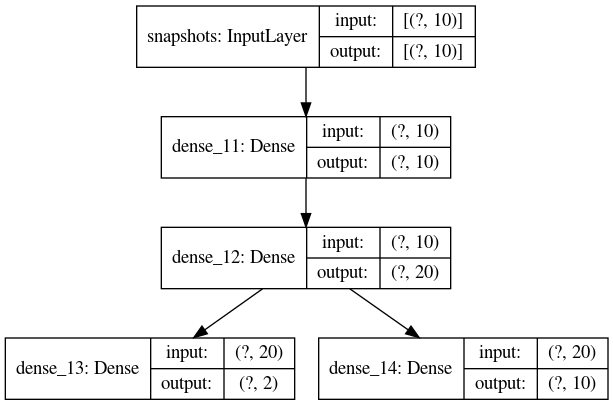

In [10]:

input_snapshots = keras.Input(shape=(len(INPUT_NAMES),),name="snapshots")
x = keras.layers.Dense(len(INPUT_NAMES))(input_snapshots)
x = keras.layers.Dense(len(INPUT_NAMES)*2, activation='tanh')(x)
output_1 = keras.layers.Dense(2, activation='tanh')(x)
output_2 = keras.layers.Dense(len(INPUT_NAMES), activation='tanh')(x)

model = keras.Model(inputs=input_snapshots,outputs=[output_1,output_2])
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)


In [14]:
took1 = train_ss_ds.take(1)
for element in took1.as_numpy_iterator():
    print(element)
took1 = train_sl_ds.take(1)
#for element in took1.as_numpy_iterator():
#    print(element)
#took1 = train_spl_ds.take(1)
#for element in took1.as_numpy_iterator():
#    print(element)

(array([[-0.373, -0.283, -0.569, -0.095, -0.203,  0.719, -0.946, -0.864,
         0.93 , -0.016],
       [-0.36 ,  0.163,  0.673, -0.335,  0.991,  0.17 , -0.437, -0.135,
        -0.395, -0.217]]), array([[-0.373, -0.283, -0.569, -0.095, -0.203,  0.719, -0.946, -0.864,
         0.93 , -0.016],
       [-0.36 ,  0.163,  0.673, -0.335,  0.991,  0.17 , -0.437, -0.135,
        -0.395, -0.217]]))


In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(len(INPUT_NAMES),input_shape=(len(INPUT_NAMES),)),
    tf.keras.layers.Dense(len(INPUT_NAMES)*2, activation='tanh'),
    tf.keras.layers.Dense(len(INPUT_NAMES)*2, activation='tanh'),
    tf.keras.layers.Dense(2, activation='tanh'),
    tf.keras.layers.Dense(len(INPUT_NAMES)*2, activation='tanh'),
    tf.keras.layers.Dense(len(INPUT_NAMES)*2, activation='tanh'),
    tf.keras.layers.Dense(len(INPUT_NAMES))])

model.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=tf.keras.losses.MeanSquaredError(),
                    metrics=[tf.keras.metrics.MeanSquaredError()])
tf.print

model.fit(train_ss_ds, epochs=10)



Train for 80305 steps
Epoch 1/10
59241/80305 [=====================>........] - ETA: 26s - loss: 0.2089 - mean_squared_error: 0.2089

KeyboardInterrupt: 

In [129]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_24 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_25 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 42        
_________________________________________________________________
dense_27 (Dense)             (None, 20)                60        
_________________________________________________________________
dense_28 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_29 (Dense)             (None, 10)               

In [130]:
example_batch, label_batch = next(iter(train_sl_ds))    


# with a Sequential model
output = K.function([model.layers[0].input],
                    [model.layers[3].output])
layer_output = output(example_batch)[0]
'''''''''''''''''''''''''''''''Do Stuff'
#print(output)
print(example_batch[0][:2])
print(layer_output[0])
print(label_batch[0])

tf.Tensor([0.673 0.176], shape=(2,), dtype=float64)
[-0.088  0.085]
tf.Tensor(1.0, shape=(), dtype=float64)


In [131]:
test_loss, test_acc = model.evaluate(test_ss_ds, verbose=1, steps = 200)

200/200 [==============================] - 0s 1ms/step - loss: 0.2169 - mean_squared_error: 0.2169


In [ ]:
encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()


In [ ]:
encoder_input = keras.Input(shape=(28, 28, 1), name='original_img')
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

decoder_input = keras.Input(shape=(16,), name='encoded_img')
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)

decoder = keras.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name='img')
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name='autoencoder')
autoencoder.summary()
